In [ ]:
from pathlib import Path
import os

DAY = "20251201"
Version = "v1"

PROJECT_ROOT = Path(os.getenv("LLMSC_ROOT", ".")).resolve()

DATA_DIR = Path(os.getenv("LLMSC_DATA_DIR", PROJECT_ROOT / "input")).resolve()
OUT_DIR  = Path(os.getenv("LLMSC_OUT_DIR",  PROJECT_ROOT / "runs" / f"{DAY}.{Version}")).resolve()
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
RANDOM_SEED = 42
import random, os
import numpy as np
random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"🔒 Random seed set to {RANDOM_SEED} for reproducibility.")


🔒 Random seed set to 42 for reproducibility.


In [ ]:
import os
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY", "")
USE_LLM = bool(GEMINI_API_KEY)

if not USE_LLM:
    print("⚠️ GEMINI_API_KEY not set → LLM inference cells will be skipped.")

In [ ]:
from __future__ import annotations

from pathlib import Path
from typing import Dict, Iterable, List, Optional, Sequence, Set, Tuple, Union

import re
from collections import Counter

import scanpy as sc
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
from scipy import sparse
from scipy import io
import adjustText
from adjustText import adjust_text
import gc
import re
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sklearn.metrics import confusion_matrix
from google.colab import userdata

import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s:%(name)s:%(message)s"
)

import llm_sc_curator
from llm_sc_curator import LLMscCurator
from llm_sc_curator.masking import FeatureDistiller
from llm_sc_curator.noise_lists import NOISE_PATTERNS

import warnings
warnings.filterwarnings("ignore")


In [ ]:
import google.generativeai as genai
MODEL_NAME = 'models/gemini-2.5-pro'
model = genai.GenerativeModel(MODEL_NAME)

In [ ]:
save_path = OUT_DIR / "cd8_benchmark_data.h5ad"

print(f"\n Loading data...: {save_path}")
adata= sc.read_h5ad(save_path)
print("\nCell counts per cluster (Should be balanced approx ~300 if 3 datasets merged):")
print(adata.obs['meta.cluster'].value_counts().head(10))


 Loading data...: /runs/20251201.v1/cd8_benchmark_data.h5ad

Cell counts per cluster (Should be balanced approx ~300 if 3 datasets merged):
meta.cluster
CD8.c01.Tn.MAL          300
CD8.c02.Tm.IL7R         300
CD8.c03.Tm.RPS12        300
CD8.c04.Tm.CD52         300
CD8.c05.Tem.CXCR5       300
CD8.c06.Tem.GZMK        300
CD8.c07.Temra.CX3CR1    300
CD8.c11.Tex.PDCD1       300
CD8.c10.Trm.ZNF683      300
CD8.c12.Tex.CXCL13      300
Name: count, dtype: int64


In [ ]:
adata.obs

,cancerType,patient,libraryID,loc,meta.cluster,platform,Cancer_Type,Sample_ID
TTGAACGCACGGATAG.13,ESCA,ESCA.P20181123,ESCA-P20181123-N,N,CD8.c07.Temra.CX3CR1,10X,ESCA,TTGAACGCACGGATAG.13
CCTAGCTGTTTCCACC.7,ESCA,ESCA.P20190410,ESCA-P20190410-N,N,CD8.c07.Temra.CX3CR1,10X,ESCA,CCTAGCTGTTTCCACC.7
TGATTTCCACCCTATC.5,ESCA,ESCA.P20190404,ESCA-P20190404-N,N,CD8.c07.Temra.CX3CR1,10X,ESCA,TGATTTCCACCCTATC.5
GGAGCAACAATCTACG.7,ESCA,ESCA.P20190410,ESCA-P20190410-N,N,CD8.c07.Temra.CX3CR1,10X,ESCA,GGAGCAACAATCTACG.7
GCACATAAGGAACTGC.10,ESCA,ESCA.P20190411,ESCA-P20190411-T,T,CD8.c07.Temra.CX3CR1,10X,ESCA,GCACATAAGGAACTGC.10
...,...,...,...,...,...,...,...,...
GTCACGGGTGGTAACG.51,RC,RC.P20190923,RC-P20190923-T,T,CD8.c15.ISG.IFIT1,10X,RC,GTCACGGGTGGTAACG.51
TCAGCTCTCTATCCCG.51,RC,RC.P20190923,RC-P20190923-T,T,CD8.c15.ISG.IFIT1,10X,RC,TCAGCTCTCTATCCCG.51
TGATTTCAGTATTGGA.51,RC,RC.P20190923,RC-P20190923-T,T,CD8.c15.ISG.IFIT1,10X,RC,TGATTTCAGTATTGGA.51
TTGCCGTCAGCCTATA.51,RC,RC.P20190923,RC-P20190923-T,T,CD8.c15.ISG.IFIT1,10X,RC,TTGCCGTCAGCCTATA.51


In [ ]:
# ==========================================
# Correct Label Generation Function
# Definition based on cluster IDs from Zheng et al. 2021
# ==========================================

def get_cd8_ground_truth(cluster_name: str) -> str:
    """
    Map Zheng et al. CD8 meta.cluster names to GT categories.

    The GT labels are intentionally slightly finer (Naive / Effector / EffectorMemory /
    Exhausted / ISG / MAIT / NK_killer / Cycling), and are later collapsed into
    coarse (major, state) pairs by CD8_HIER_CFG.gt_rules.
    """
    s = str(cluster_name).lower()

    # 1) Distinct functional states
    if "mait" in s:
        return "CD8_MAIT"

    if any(k in s for k in ["isg", "interferon", "ifit1"]):
        return "CD8_ISG"

    if any(k in s for k in ["proliferating", "cycle", "mki67", "top2a"]):
        return "CD8_Cycling"

    # 2) NK-like killer pool (exclude explicit T cell labels)
    if "nk" in s and "t cell" not in s:
        return "CD8_NK_Killer"

    # 3) Exhausted pool
    if any(k in s for k in ["tex", "exhausted", "pdcd1"]):
        return "CD8_Exhausted"

    # 4) TRM / resident memory → treated as EffectorMemory in GT
    if any(k in s for k in ["trm", "resident", "znf683", "itgae", "cd69"]):
        return "CD8_EffectorMemory"

    # 5) Naive pool (true naive; use 'tn.' to avoid Tn/Tm confusion)
    if "tn." in s or "naive" in s:
        return "CD8_Naive"

    # 6) Temra / CX3CR1-high killers
    if any(k in s for k in ["temra", "cx3cr1", "klrg1"]):
        return "CD8_Effector"

    # 7) Tem / Tm / GZMK+ effector-memory clusters
    if any(k in s for k in ["tem.", "tm.", "memory", "gzmk", "aqp3", "ltb"]):
        return "CD8_EffectorMemory"

    # 8) Tk / killer T clusters (Zheng's Tk)
    if "tk" in s or "killer" in s:
        return "CD8_Effector"

    # 9) Fallback
    return "CD8_Other"



print("Applying Ground Truth Mapping...")
adata.obs['GT_Category'] = adata.obs['meta.cluster'].apply(get_cd8_ground_truth)
print(adata.obs['GT_Category'].value_counts())

Applying Ground Truth Mapping...
GT_Category
CD8_EffectorMemory    1983
CD8_Exhausted          928
CD8_Effector           753
CD8_Naive              300
CD8_MAIT               300
CD8_ISG                202
Name: count, dtype: int64


In [ ]:
GT_KEYWORDS_CD8 = {
    "CD8_Exhausted":      ["PDCD1", "HAVCR2", "LAG3", "TOX"],
    "CD8_ISG":            ["ISG15", "IFIT1", "MX1", "STAT1"],
    "CD8_EffectorMemory": ["GZMK", "LTB", "AQP3"],
    "CD8_Effector":       ["GZMB", "PRF1", "GNLY", "CX3CR1", "KLRG1"],
    "CD8_MAIT":           ["SLC4A10", "KLRB1"],
    "CD8_Naive":          ["TCF7", "LEF1", "CCR7", "SELL"],
    "CD8_Cycling":        ["MKI67", "TOP2A"],
}


var_names = adata.var_names
filtered_markers = {k: [g for g in v if g in var_names] for k, v in GT_KEYWORDS_CD8.items()}

In [ ]:
if "highly_variable" not in adata.var.columns:
    print("[Setup] Computing global HVGs for CD8 benchmark...")

    hvg_kwargs = dict(
        n_top_genes=2000,
        subset=False,
        batch_key="Cancer_Type",
    )

    if "counts" in adata.layers:
        hvg_kwargs.update(
            flavor="seurat_v3",
            layer="counts",
        )
        print("[HVG] Using flavor='seurat_v3' on layers['counts'] with batch_key='Cancer_Type'.")
    else:
        hvg_kwargs.update(
            flavor="seurat",
        )
        print("[HVG] `layers['counts']` not found → using flavor='seurat' on log1p .X.")

    print(hvg_kwargs)

    sc.pp.highly_variable_genes(adata, **hvg_kwargs)

# Curator Initialize
curator = LLMscCurator(api_key=GEMINI_API_KEY, model_name=MODEL_NAME)
curator.set_global_context(adata)

[Setup] Computing global HVGs for CD8 benchmark...
[HVG] Using flavor='seurat_v3' on layers['counts'] with batch_key='Cancer_Type'.
{'n_top_genes': 2000, 'subset': False, 'batch_key': 'Cancer_Type', 'flavor': 'seurat_v3', 'layer': 'counts'}


In [ ]:
def _save_source_data_masking_landscape(
    plot_df,
    *,
    cluster: str,
    stem: str,
    out_dir: Path,
    target_genes: List[str],
    signature_gene: Optional[str],
    extras: List[str],
    fig_id: str = "EDFigX",
) -> Path:
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    df = plot_df.copy()
    df = df.reset_index().rename(columns={"index": "gene"})
    df["cluster"] = str(cluster)

    tset = set(map(str, target_genes))
    eset = set(map(str, extras))
    sig = str(signature_gene) if signature_gene is not None else ""

    df["is_labeled"] = df["gene"].astype(str).isin(tset)
    df["is_signature"] = df["gene"].astype(str).eq(sig) if sig else False
    df["is_extra"] = df["gene"].astype(str).isin(eset) | df["gene"].astype(str).isin({e.upper() for e in eset})

    # Rank in local_mean (higher values indicate higher rank)
    if "local_mean" in df.columns:
        df["rank_local_mean"] = df["local_mean"].rank(ascending=False, method="min").astype(int)

    # Source Data outputs columns in a fixed order (sequence also fixed)
    cols = [
        "cluster", "gene",
        "gini", "local_mean", "log_local_mean",
        "Status", "Reason", "Category",
        "is_labeled", "is_signature", "is_extra",
        "rank_local_mean",
    ]
    cols = [c for c in cols if c in df.columns]

    out_csv = out_dir / f"SourceData_{fig_id}_masking_landscape__{stem}.csv"
    df[cols].to_csv(out_csv, index=False)
    return out_csv


In [ ]:
def _safe_stem(s: str) -> str:
    s = str(s)
    s = s.strip()
    s = re.sub(r"[^\w\-.]+", "_", s)  # file-safe
    return s[:180]  # avoid too-long filenames


def Gini_coef_log_mean_exp_plots(
    curator,
    adata,
    out_path: Union[str, Path] = "Supplementary_Figure_All_Clusters.pdf",
    *,
    out_dir: Optional[Union[str, Path]] = None,
    save_mode: str = "multi",  # "multi" | "split" | "both"
    save_png: bool = False,
    png_dpi: int = 300,
    group_col: str = "meta.cluster",
    gini_threshold: float = 0.15,
    top_n: int = 15,
    # --- figure policy (final-size first) ---
    fig_size_in: Tuple[float, float] = (6.1, 4.8),
    pad_inches: float = 0.03,
    bbox_tight: bool = True,
    # --- typography (a bit larger) ---
    tick_fs: int = 12,
    axis_label_fs: int = 14,
    title_fs: int = 12,
    gene_fs: int = 11,
    signature_gene_fs: int = 13,
    legend_fs: int = 11,
    # --- legend policy ---
    legend_clusters: Set[str] = frozenset({"CD8.c02.Tm.IL7R", "CD8.c01.Tn.MAL"}),
    legend_loc: str = "upper right",
    extra_label_genes_by_cluster: Optional[Dict[str, List[str]]] = None,
    extra_gene_fs: int = 12,
    extra_gene_color: str = "#1565C0", 
):
    """
    Save masking landscape per cluster.
    - save_mode="multi": Only one multi-page PDF
    - save_mode="split": Individual PDFs per cluster
    - save_mode="both": Both
    """
    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)

    if out_dir is None:
        out_dir = out_path.with_suffix("")  # e.g. Supplementary_Figure_All_Clusters/
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    # --- global stats preparation ---
    if curator.masker is None or curator.masker.gene_stats is None:
        _ = curator.curate_features(
            adata,
            group_col=group_col,
            target_group=adata.obs[group_col].iloc[0],
            n_top=10,
        )

    global_stats = curator.masker.gene_stats.copy()
    mask_reasons = curator.masker.detect_biological_noise(gini_threshold=gini_threshold)

    global_stats["Status"] = "Kept"
    global_stats["Reason"] = "None"
    for gene, reason in mask_reasons.items():
        if gene in global_stats.index:
            global_stats.loc[gene, "Status"] = "Filtered"
            global_stats.loc[gene, "Reason"] = reason

    def simplify_reason(r: str) -> str:
        if r == "None":
            return "Kept"
        if "Low_Gini" in r:
            return "Housekeeping (Low Gini)"
        if "Ribo" in r or "Mito" in r:
            return "Tech Noise (Mito/Ribo)"
        if "TCR" in r or "Ig" in r:
            return "Lineage Noise (TCR/Ig)"
        if "CellCycle" in r:
            return "State Noise (Cell Cycle)"
        if "Translation" in r:
            return "Translation Factor"
        return "Other Noise"

    global_stats["Category"] = global_stats["Reason"].apply(simplify_reason)

    palette: Dict[str, str] = {
        "Kept": "#E0E0E0",
        "Housekeeping (Low Gini)": "#FFB74D",
        "Tech Noise (Mito/Ribo)": "#EF5350",
        "Lineage Noise (TCR/Ig)": "#AB47BC",
        "State Noise (Cell Cycle)": "#42A5F5",
        "Translation Factor": "#66BB6A",
        "Other Noise": "#78909C",
    }
    legend_order: Sequence[str] = [
        "Housekeeping (Low Gini)",
        "Tech Noise (Mito/Ribo)",
        "Lineage Noise (TCR/Ig)",
        "State Noise (Cell Cycle)",
        "Translation Factor",
        "Other Noise",
    ]

    # PDF text as TrueType
    plt.rcParams["pdf.fonttype"] = 42
    plt.rcParams["ps.fonttype"] = 42
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]

    unique_clusters = adata.obs[group_col].unique()

    # outputs
    split_pdfs: List[Path] = []
    split_pngs: List[Path] = []

    # multipage PDF handle (optional)
    pdf = None
    if save_mode in ("multi", "both"):
        pdf = PdfPages(out_path)

    try:
        for cluster in unique_clusters:
            stem = _safe_stem(cluster)

            # --- signature gene extraction ---
            signature_gene: Optional[str]
            try:
                signature_gene = str(cluster).split(".")[-1]
                if signature_gene not in adata.var_names:
                    if signature_gene.upper() in adata.var_names:
                        signature_gene = signature_gene.upper()
                    else:
                        signature_gene = None
            except Exception:
                signature_gene = None

            # --- cluster-specific means ---
            cells = adata[adata.obs[group_col] == cluster]
            if scipy.sparse.issparse(cells.X):
                local_mean = cells.X.mean(axis=0).A1
            else:
                local_mean = np.asarray(cells.X.mean(axis=0)).ravel()

            plot_df = global_stats.copy()
            plot_df["local_mean"] = local_mean
            plot_df["log_local_mean"] = np.log1p(plot_df["local_mean"])

            # --- target genes (top N + signature) ---
            top_indices = local_mean.argsort()[::-1][:top_n]
            target_genes = adata.var_names[top_indices].tolist()
            if signature_gene and signature_gene not in target_genes:
                target_genes.append(signature_gene)

            extras = []
            if extra_label_genes_by_cluster:
                extras = extra_label_genes_by_cluster.get(str(cluster), [])

            # Only those present in var_names are adopted
            vset = set(map(str, adata.var_names))
            for g in extras:
                g = str(g)
                if g in vset and g not in target_genes:
                    target_genes.append(g)
                elif g.upper() in vset and g.upper() not in target_genes:
                    target_genes.append(g.upper())

            # --- plotting ---
            fig, ax = plt.subplots(figsize=fig_size_in)

            kept = plot_df[plot_df["Category"] == "Kept"]
            ax.scatter(
                kept["log_local_mean"], kept["gini"],
                c=palette["Kept"], s=15, alpha=0.35,
                edgecolors="none", label="_nolegend_",
            )

            handles_by_cat = {}
            for cat in legend_order:
                sub = plot_df[plot_df["Category"] == cat]
                if sub.shape[0] == 0:
                    continue
                sca = ax.scatter(
                    sub["log_local_mean"], sub["gini"],
                    c=palette.get(cat, "black"),
                    s=22, alpha=0.85,
                    edgecolors="white", linewidth=0.3,
                    label=cat,
                )
                handles_by_cat[cat] = sca

            ax.axhline(y=gini_threshold, color="black", linestyle="--", linewidth=1, alpha=0.6)


            extra_set = set()
            if extra_label_genes_by_cluster:
                extra_set = set(map(str, extra_label_genes_by_cluster.get(str(cluster), [])))

            texts = []
            for gene in target_genes:
                if gene not in plot_df.index:
                    continue
                row = plot_df.loc[gene]
                if signature_gene and gene == signature_gene:
                    t = ax.text(
                        row["log_local_mean"], row["gini"], gene,
                        fontsize=signature_gene_fs, fontweight="bold",
                        color="#D32F2F",
                    )

                elif str(gene) in extra_set or str(gene).upper() in extra_set:
                    t = ax.text(
                        row["log_local_mean"], row["gini"], gene,
                        fontsize=extra_gene_fs, fontweight="bold",
                        color=extra_gene_color,
                    )
                else:
                    t = ax.text(
                        row["log_local_mean"], row["gini"], gene,
                        fontsize=gene_fs, fontweight="bold", color="black",
                    )
                texts.append(t)

            adjust_text(
                texts, ax=ax,
                arrowprops=dict(arrowstyle="-", color="black", lw=0.5),
                force_points=0.3, force_text=0.5, expand_points=(1.2, 1.2),
            )

            ax.set_xlabel(f"Log mean expression ({cluster})", fontsize=axis_label_fs, fontweight="bold")
            ax.set_ylabel("Global Gini coefficient (specificity)", fontsize=axis_label_fs, fontweight="bold")
            ax.set_title(f"", fontsize=title_fs, fontweight="bold")
            ax.tick_params(axis="both", labelsize=tick_fs)
            ax.grid(True, which="major", linestyle=":", linewidth=0.5, alpha=0.5)

            # Legend only for the two main clusters, inside top-right, no frame
            if str(cluster) in set(legend_clusters):
                ordered_handles = [handles_by_cat[c] for c in legend_order if c in handles_by_cat]
                ordered_labels = [c for c in legend_order if c in handles_by_cat]
                if ordered_handles:
                    ax.legend(
                        ordered_handles, ordered_labels,
                        loc=legend_loc, frameon=True,
                        fontsize=legend_fs,
                        borderaxespad=0.1, handletextpad=0.2, labelspacing=0.2,
                    )

            fig.tight_layout()

            save_kw = {}
            if bbox_tight:
                save_kw.update(dict(bbox_inches="tight", pad_inches=pad_inches))

            # --- write to multipage ---
            if pdf is not None:
                pdf.savefig(fig, **save_kw)

            # --- write split files ---
            if save_mode in ("split", "both"):
                stem = _safe_stem(cluster)
                one_pdf = out_dir / f"{stem}.pdf"
                fig.savefig(one_pdf, dpi=300, **save_kw)
                split_pdfs.append(one_pdf)

                if save_png:
                    one_png = out_dir / f"{stem}.png"
                    fig.savefig(one_png, dpi=png_dpi, **save_kw)
                    split_pngs.append(one_png)

            source_dir = out_dir / "source_data_masking_landscape"
            one_sd = _save_source_data_masking_landscape(
                plot_df,
                cluster=str(cluster),
                stem=stem,
                out_dir=source_dir,
                target_genes=target_genes,
                signature_gene=signature_gene,
                extras=extras,
                fig_id="EDFig1a",
            )

            plt.close(fig)

    finally:
        if pdf is not None:
            pdf.close()

    return {
        "multi_pdf": out_path if save_mode in ("multi", "both") else None,
        "split_dir": out_dir if save_mode in ("split", "both") else None,
        "split_pdfs": split_pdfs,
        "split_pngs": split_pngs,
    }

res = Gini_coef_log_mean_exp_plots(
    curator, adata,
    save_mode="both",
    out_path=f"{OUT_DIR}/Fig1b_EDFig1a.pdf",
    out_dir=f"{OUT_DIR}/Fig1b_EDFig1a",
    extra_label_genes_by_cluster={
        "CD8.c02.Tm.IL7R": ["CCR7","TCF7","LEF1","SELL","LTB","AQP3","CD27","KLF2","S1PR1"]
    },
)

In [ ]:
# --- 1. Definition of Noise Patterns---
def generate_noise_set(all_genes, patterns=NOISE_PATTERNS):
    """Automatically generate noise sets matching regular expressions from gene lists"""
    noise_set = set()
    for gene in all_genes:
        for cat, pattern in patterns.items():
            if re.search(pattern, gene):
                noise_set.add(gene)
                break
    return noise_set


In [ ]:
# --- 1. First, retrieve the low-Gini housekeeping set again. ---
gs = curator.masker.gene_stats.copy()
gs = gs.replace([np.inf, -np.inf], np.nan).dropna(subset=["gini", "mean"])

gini_q     = 0.01
mean_floor = 0.01

mask_reasons = curator.masker.detect_biological_noise(
    gini_threshold=None,
    gini_q=gini_q,
    mean_floor=mean_floor,
)

low_gini_genes = {
    g for g, reason in mask_reasons.items()
    if isinstance(reason, str) and reason.startswith("Low_Gini_Housekeeping")
}

print(f"Low-Gini housekeeping genes: {len(low_gini_genes)}")

# --- 2. Examining the relationship between gene lists (Standard vs Curated) and Low-Gini in a given cluster ---
def inspect_cluster_effect(
    adata,
    curator,
    cluster_name: str,
    group_col: str = "meta.cluster",
    N_STD: int = 50,
    N_DE_CAND: int = 500,
):

    print(f"\n========== Inspecting cluster: {cluster_name} ==========")

    # A. Calculate the DE and obtain the Top N_STD
    adata_tmp = adata.copy()
    adata_tmp.obs["binary_group"] = "Rest"
    adata_tmp.obs.loc[adata_tmp.obs[group_col] == cluster_name, "binary_group"] = "Target"

    sc.tl.rank_genes_groups(
        adata_tmp,
        groupby="binary_group",
        groups=["Target"],
        reference="Rest",
        method="wilcoxon",
        use_raw=False,
    )
    df_std = sc.get.rank_genes_groups_df(adata_tmp, group="Target")
    genes_std = df_std["names"].tolist()
    std_top = genes_std[:N_STD]

    # B. Curated: Actually calls curate_features
    genes_cur = curator.curate_features(
        target_adata=adata,
        group_col=group_col,
        target_group=cluster_name,
        n_top=N_STD,
        n_candidates=N_DE_CAND,
        use_statistics=True,
    )

    # C. Examine the proportion of genes included in the Low-Gini category within each list
    std_low = [g for g in std_top if g in low_gini_genes]
    cur_low = [g for g in genes_cur     if g in low_gini_genes]

    print(f"Standard top {N_STD}: {len(std_low)} Low-Gini genes")
    print(f"Curated  top {N_STD}: {len(cur_low)} Low-Gini genes")

    print("\n例: Standard top Low-Gini genes:")
    print(std_low[:20])

    print("\n例: Curated top Low-Gini genes:")
    print(cur_low[:20])

    print("\nStandard top genes:")
    print(std_top[:20])

    print("\nCurated top genes:")
    print(genes_cur[:20])

    return {
        "std_top": std_top,
        "cur_top": genes_cur,
        "std_low": std_low,
        "cur_low": cur_low,
    }

# As a specific example, check the IL7R memory cluster.
res_il7r = inspect_cluster_effect(
    adata=adata,
    curator=curator,
    cluster_name="CD8.c02.Tm.IL7R",
    group_col="meta.cluster",
    N_STD=50,
    N_DE_CAND=500,
)


Low-Gini housekeeping genes: 21

========== Inspecting cluster: CD8.c02.Tm.IL7R ==========
Standard top 50: 4 Low-Gini genes
Curated  top 50: 0 Low-Gini genes

例: Standard top Low-Gini genes:
['BTG1', 'SRGN', 'AC090498.1', 'FTH1']

例: Curated top Low-Gini genes:
[]

Standard top genes:
['ZFP36L2', 'CXCR4', 'BTG1', 'ZFP36', 'ANXA1', 'IL7R', 'TSC22D3', 'SARAF', 'GLIPR1', 'LEPROTL1', 'KLF6', 'PTGER4', 'RGCC', 'FAM129A', 'TNFAIP3', 'FOSB', 'MYADM', 'CYTIP', 'RPS3A', 'SAMSN1']

Curated top genes:
['ZFP36L2', 'ZFP36', 'ANXA1', 'IL7R', 'TSC22D3', 'KLF6', 'RGCC', 'CD55', 'LMNA', 'GPR183', 'TOB1', 'DUSP1', 'VIM', 'CD69', 'CCL4', 'CITED2', 'TUBA4A', 'PIK3R1', 'SLC2A3', 'NR4A2']


In [ ]:
def plot_rank_shift(
    standard_genes: Sequence[str],
    curated_genes: Sequence[str],
    *,
    noise_genes_set: Optional[Set[str]] = None,
    noise_patterns: Dict[str, str] = NOISE_PATTERNS,
    top_n: int = 50,
    curated_top_red_k: int = 10,
    # --- figure policy ---
    fig_size_in: Tuple[float, float] = (3.55, 5.6),
    pad_inches: float = 0.03,
    bbox_tight: bool = True,
    dpi: int = 300,
    # --- typography ---
    tick_fs: int = 10,
    axis_label_fs: int = 12,
    gene_fs: int = 7,
    x_label: Optional[str] = None,
    # --- legend ---
    legend_fs: int = 9,
    legend_ncol: int = 3,
    bold_right_genes: Optional[Sequence[str]] = None,
    bold_right_gene_fs: Optional[int] = None,
    # --- outputs ---
    out_pdf: Optional[Union[str, Path]] = None,
    out_png: Optional[Union[str, Path]] = None,
    source_data_csv: Optional[Union[str, Path]] = None,
) -> Tuple[plt.Figure, plt.Axes, pd.DataFrame]:

    std = list(map(str, standard_genes))
    cur = list(map(str, curated_genes))
    std_top = std[:top_n]
    cur_top = cur[:top_n]

    display_genes = list(dict.fromkeys(std_top + cur_top))

    if noise_genes_set is None:
        noise_genes_set = generate_noise_set(display_genes, noise_patterns)
    noise_set = set(map(str, noise_genes_set))

    ghost_rank = top_n + 5
    std_rank = {g: i + 1 for i, g in enumerate(std)}
    cur_rank = {g: i + 1 for i, g in enumerate(cur)}

    bold_right_set = set()
    if bold_right_genes:
        bold_right_set = {str(g).upper() for g in bold_right_genes}

    rows = []
    for g in display_genes:
        r_std = min(std_rank.get(g, ghost_rank), ghost_rank)
        r_cur = min(cur_rank.get(g, ghost_rank), ghost_rank)
        is_noise = g in noise_set
        in_std_top = r_std <= top_n
        in_cur_top = r_cur <= top_n

        if r_cur <= curated_top_red_k:
            cat = "CuratorTop"
        elif is_noise and in_std_top and (not in_cur_top):
            cat = "NoiseDropped"
        else:
            cat = "Other"

        rows.append(
            dict(
                gene=g,
                rank_std=r_std,
                rank_cur=r_cur,
                is_noise=is_noise,
                category=cat,
                is_ghost_std=(r_std == ghost_rank),
                is_ghost_cur=(r_cur == ghost_rank),
            )
        )

    df = pd.DataFrame(rows).sort_values(["rank_cur", "rank_std"]).reset_index(drop=True)

    plt.rcParams["pdf.fonttype"] = 42
    plt.rcParams["ps.fonttype"] = 42
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]

    fig, ax = plt.subplots(figsize=fig_size_in, dpi=dpi)

    x_std, x_cur = 0, 1
    y_max = ghost_rank + 1
    ax.set_ylim(y_max, 0)
    ax.set_xlim(-0.7, 1.7)

    for y in range(1, top_n + 1):
        ax.hlines(y, x_std - 0.08, x_cur + 0.08, color="#F0F0F0", lw=0.5, zorder=0)
    ax.fill_between([-1, 2], [top_n + 0.5] * 2, [y_max] * 2, color="#FAFAFA", zorder=0)

    styles = {
        "CuratorTop":   dict(color="#D32F2F", alpha=1.0, lw=2.0, zorder=5),
        "NoiseDropped": dict(color="#0288D1", alpha=0.9, lw=1.3, zorder=4),
        "Other":        dict(color="#D9D9D9", alpha=0.7, lw=0.9, zorder=1),
    }

    for _, row in df.iterrows():
        st = styles[row["category"]]

        ax.plot([x_std, x_cur], [row["rank_std"], row["rank_cur"]],
                color=st["color"], alpha=st["alpha"], lw=st["lw"], zorder=st["zorder"])

        if not row["is_ghost_std"]:
            ax.scatter(x_std, row["rank_std"], color=st["color"], s=20, zorder=st["zorder"] + 1)
        if not row["is_ghost_cur"]:
            ax.scatter(x_cur, row["rank_cur"], color=st["color"], s=20, zorder=st["zorder"] + 1)

        # left labels
        if not row["is_ghost_std"]:
            ax.text(x_std - 0.10, row["rank_std"], row["gene"],
                    ha="right", va="center", fontsize=gene_fs, color="#333333")

        # right labels
        if not row["is_ghost_cur"]:
            g = str(row["gene"])
            is_bold = (g.upper() in bold_right_set)
            ax.text(
                x_cur + 0.10, row["rank_cur"], g,
                ha="left", va="center",
                fontsize=(bold_right_gene_fs if (is_bold and bold_right_gene_fs) else gene_fs),
                color="#333333",
                fontweight=("bold" if is_bold else "normal"),
            )

    ax.set_xticks([x_std, x_cur])
    ax.set_xticklabels(["Standard", "LLM-scCurator"], fontsize=tick_fs, fontweight="bold")
    ax.set_ylabel("Gene rank", fontsize=axis_label_fs, fontweight="bold")
    if x_label:
        ax.set_xlabel(x_label, fontsize=axis_label_fs, fontweight="bold", labelpad=10)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis="x", length=0)

    handles = [
        Line2D([0], [0], color=styles["CuratorTop"]["color"],   lw=2.2, label=f"LLM-scCurator top {curated_top_red_k}"),
        Line2D([0], [0], color=styles["NoiseDropped"]["color"], lw=1.6, label="Noise dropped"),
    ]
    ax.legend(
        handles=handles,
        loc="lower center",
        bbox_to_anchor=(0.5, 1.02),
        ncol=legend_ncol,
        frameon=False,
        fontsize=legend_fs,
        handletextpad=0.6,
        columnspacing=1.2,
    )

    fig.tight_layout()

    save_kwargs = {"dpi": dpi}
    if bbox_tight:
        save_kwargs.update({"bbox_inches": "tight", "pad_inches": pad_inches})

    if out_pdf is not None:
        out_pdf = Path(out_pdf); out_pdf.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(out_pdf, **save_kwargs)

    if out_png is not None:
        out_png = Path(out_png); out_png.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(out_png, **save_kwargs)

    if source_data_csv is not None:
        source_data_csv = Path(source_data_csv); source_data_csv.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(source_data_csv, index=False)

    return fig, ax, df


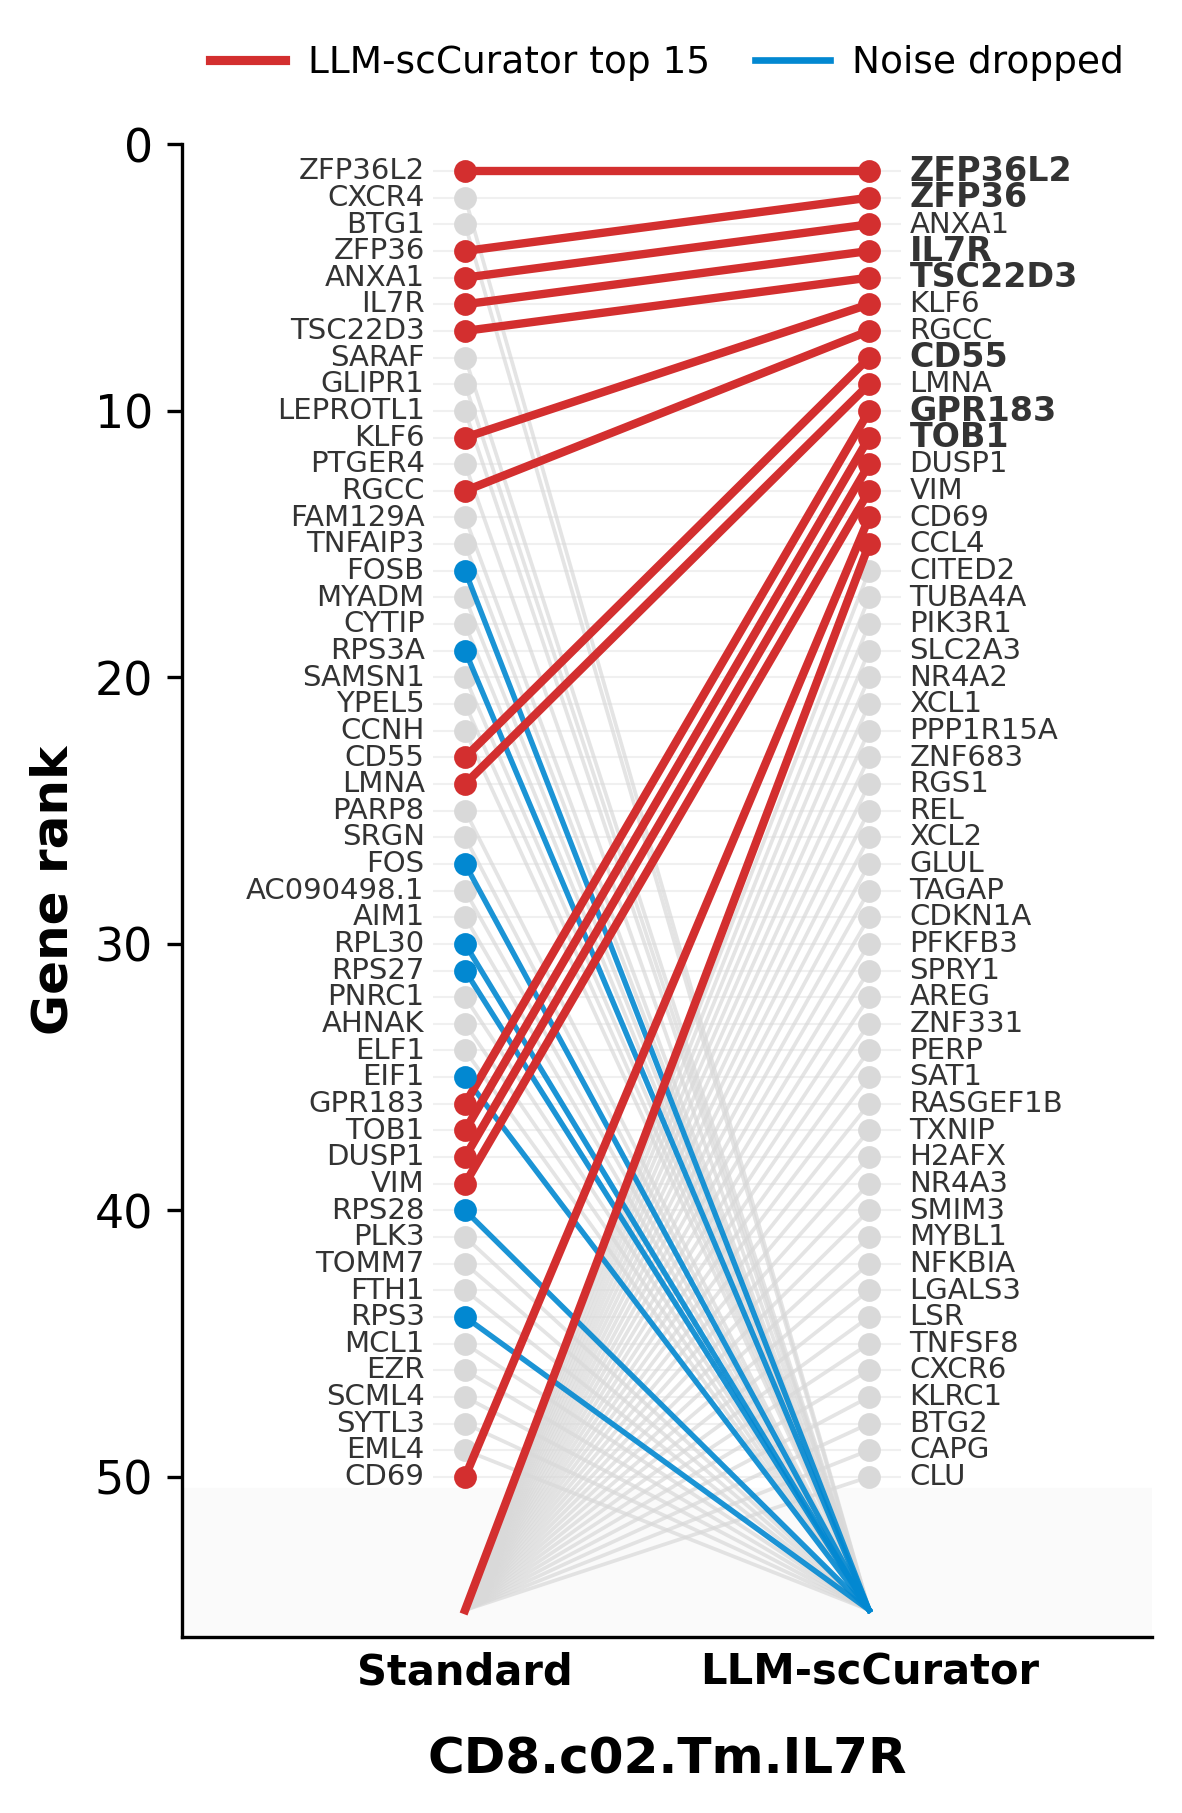

In [ ]:
bold_list = ["IL7R", "GPR183", "TSC22D3", "ZFP36L2", "ZFP36", "TOB1", "CD55"]

fig, ax, df = plot_rank_shift(
    standard_genes=res_il7r["std_top"],
    curated_genes=res_il7r["cur_top"],
    top_n=50,
    curated_top_red_k=15,
    x_label="CD8.c02.Tm.IL7R",
    fig_size_in=(4.1, 6.2),
    bold_right_genes=bold_list,
    bold_right_gene_fs=8,
    out_pdf = f"{OUT_DIR}/Fig1c_RankShift.pdf",
    source_data_csv = f"{OUT_DIR}/Fig1c_data.csv",
)


🚀 Analyzing Noise Composition with Unified Palette...
✅ Unified figure generated: /runs/20251201.v1/Fig2e.noise_landscape.png
✅ Source Data saved: /runs/20251201.v1/SourceData/Fig2e.raw.csv
✅ Source Data saved: /runs/20251201.v1/SourceData/Fig2e.data.csv


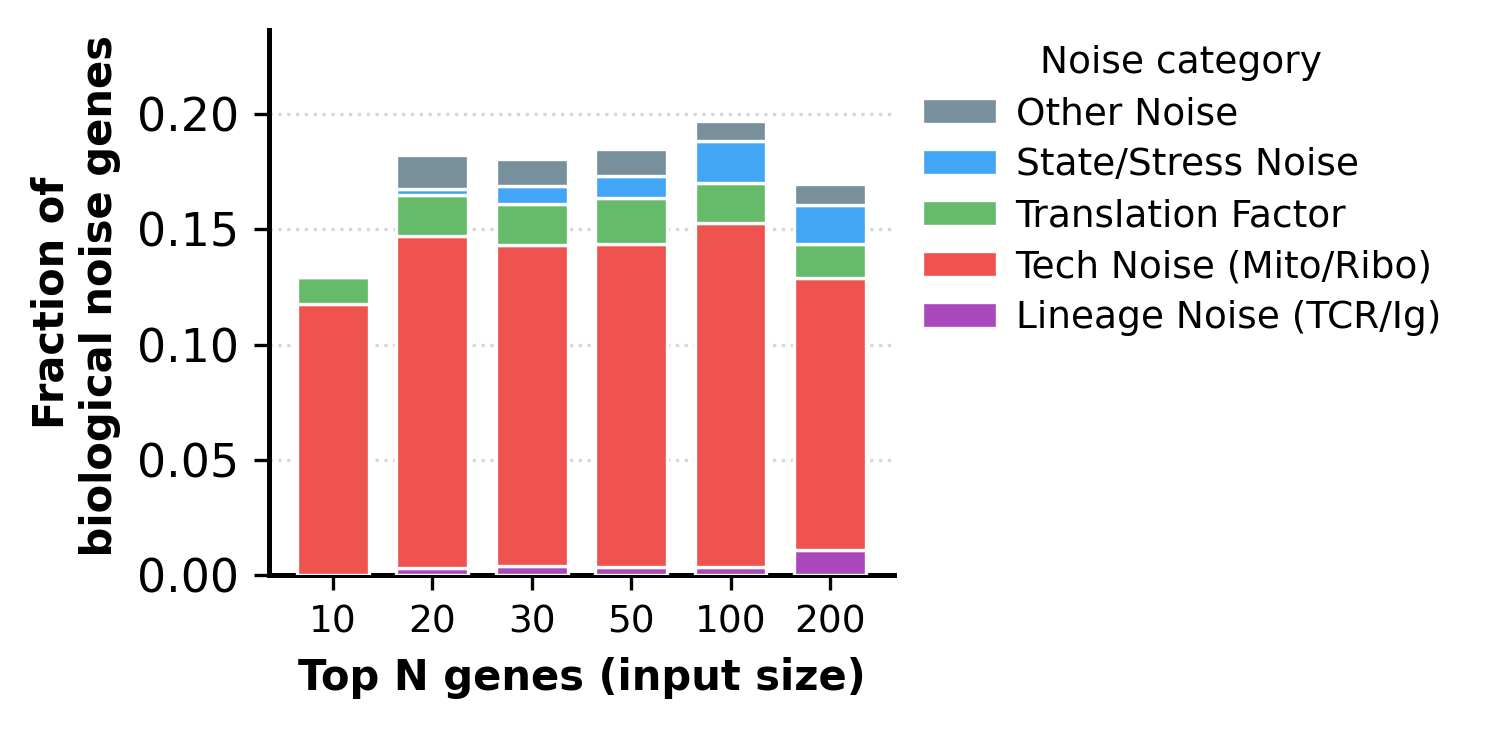

In [ ]:
# ==========================================
# 1) Unified Visual Identity (consistent)
# ==========================================

NOISE_PALETTE = {
    "Kept": "#E0E0E0",
    "Housekeeping (Low Gini)": "#FFB74D",
    "Tech Noise (Mito/Ribo)": "#EF5350",
    "Lineage Noise (TCR/Ig)": "#AB47BC",
    "State/Stress Noise": "#42A5F5",
    "Translation Factor": "#66BB6A",
    "Other Noise": "#78909C",
}

# stack order (bottom -> top)
PLOT_ORDER = [
    "Lineage Noise (TCR/Ig)",
    "Tech Noise (Mito/Ribo)",
    "Translation Factor",
    "State/Stress Noise",
    "Other Noise",
]


def map_pattern_to_category(pattern_name: str) -> str:
    """
    Map NOISE_PATTERNS keys -> unified category.
    """
    p = str(pattern_name)

    if ("TCR" in p) or ("Ig_" in p) or ("IG_" in p) or ("BCR" in p):
        return "Lineage Noise (TCR/Ig)"

    if ("Mito" in p) or ("Ribo" in p) or ("MT_" in p) or ("RPL" in p) or ("RPS" in p):
        return "Tech Noise (Mito/Ribo)"

    if "Translation" in p:
        return "Translation Factor"

    # stress/state-like programs
    if ("CellCycle" in p) or ("HeatShock" in p) or ("JunFos" in p) or ("Stress" in p) or ("IFN" in p):
        return "State/Stress Noise"

    return "Other Noise"


def calculate_noise_breakdown_unified(
    gene_list: Sequence[str],
    *,
    patterns: Dict[str, str] = NOISE_PATTERNS,
    regex_flags: int = 0,
) -> Tuple[Dict[str, int], int]:
    """
    Count noise categories in a gene list using unified categories.
    - 1 gene -> 1 category (first match wins)
    Returns: (breakdown dict for PLOT_ORDER, total_noise_count)
    """
    breakdown = Counter({cat: 0 for cat in PLOT_ORDER})

    if not gene_list:
        return dict(breakdown), 0

    compiled = [(k, re.compile(rx, flags=regex_flags)) for k, rx in patterns.items()]

    total_noise = 0
    for g in gene_list:
        gs = str(g)
        matched = False
        for pattern_name, creg in compiled:
            if creg.search(gs):
                cat = map_pattern_to_category(pattern_name)
                breakdown[cat] += 1
                matched = True
                break
        if matched:
            total_noise += 1

    return dict(breakdown), total_noise


# ==========================================
# 2) Main runner: compute per cluster × Top_N
# ==========================================

def compute_noise_landscape(
    adata,
    *,
    groupby: str = "meta.cluster",
    rank_key: str = "llmsc_rank_genes",
    method: str = "wilcoxon",
    use_raw: bool = False,
    n_genes_list: Sequence[int] = (10, 20, 30, 50, 100, 200),
    patterns: Dict[str, str] = NOISE_PATTERNS,
) -> pd.DataFrame:
    """
    Returns long-ish stats table with columns:
    Cluster, Top_N, <each category count>, Total_Noise, Noise_Fraction
    """
    clusters = adata.obs[groupby].unique().tolist()

    if rank_key not in adata.uns:
        sc.tl.rank_genes_groups(adata, groupby=groupby, method=method, use_raw=use_raw, key_added=rank_key)

    rows = []
    for cluster in clusters:
        df_rg = sc.get.rank_genes_groups_df(adata, group=cluster, key=rank_key)
        all_genes = df_rg["names"].astype(str).tolist()

        for n in n_genes_list:
            top_genes = all_genes[: int(n)]
            breakdown, total_noise = calculate_noise_breakdown_unified(top_genes, patterns=patterns)

            row = {"Cluster": cluster, "Top_N": int(n), "Total_Noise": int(total_noise)}
            for cat in PLOT_ORDER:
                row[cat] = int(breakdown.get(cat, 0))
            row["Noise_Fraction"] = float(total_noise) / float(n) if n else 0.0
            rows.append(row)

    return pd.DataFrame(rows)


# ==========================================
# 3) Aggregate + 95% CI across clusters
# ==========================================

def summarize_noise_landscape(
    df_stats: pd.DataFrame,
    *,
    n_genes_list: Sequence[int],
) -> pd.DataFrame:
    """
    Summary per Top_N and category:
    mean fraction + 95% CI across clusters (normal approx).
    """
    out_rows = []
    for n in n_genes_list:
        sub = df_stats[df_stats["Top_N"] == int(n)]
        if sub.empty:
            continue

        for cat in PLOT_ORDER:
            frac = sub[cat].to_numpy(dtype=float) / float(n)
            m = float(np.mean(frac))
            sd = float(np.std(frac, ddof=1)) if len(frac) >= 2 else 0.0
            se = sd / np.sqrt(max(len(frac), 1))
            ci = 1.96 * se
            out_rows.append(
                dict(
                    Top_N=int(n),
                    Category=cat,
                    mean=m,
                    lower=max(0.0, m - ci),
                    upper=min(1.0, m + ci),
                    n_clusters=len(frac),
                )
            )

    return pd.DataFrame(out_rows)


# ==========================================
# 4) Plot (Nature-safe)
# ==========================================

def plot_noise_landscape_stacked(
    summary: pd.DataFrame,
    *,
    n_genes_list: Sequence[int],
    fig_size_in: Tuple[float, float] = (3.55, 2.4),  # half-width
    dpi: int = 300,
    pad_inches: float = 0.03,
    bbox_tight: bool = True,
    font_size: int = 9,
    axis_label_fs: int = 10,
    tick_fs: int = 9,
    legend_fs: int = 9,
    legend_ncol: int = 3,
    out_png: Optional[Union[str, Path]] = None,
    out_pdf: Optional[Union[str, Path]] = None,
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Stacked bar of mean fractions per Top_N.
    (CI bands for stacks are visually messy, so we keep CI in Source Data.)
    """
    # pivot to Top_N x Category mean
    pivot = (
        summary.pivot_table(index="Top_N", columns="Category", values="mean", aggfunc="first")
        .reindex(index=list(map(int, n_genes_list)))
        .fillna(0.0)
    )

    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
    plt.rcParams["font.size"] = font_size
    plt.rcParams["axes.linewidth"] = 1.2
    plt.rcParams["pdf.fonttype"] = 42
    plt.rcParams["ps.fonttype"] = 42

    fig, ax = plt.subplots(figsize=fig_size_in, dpi=dpi)

    x = np.arange(len(n_genes_list))
    bottom = np.zeros(len(n_genes_list), dtype=float)

    for cat in PLOT_ORDER:
        vals = pivot[cat].to_numpy()
        ax.bar(
            x,
            vals,
            bottom=bottom,
            width=0.72,
            color=NOISE_PALETTE[cat],
            edgecolor="white",
            linewidth=0.8,
            label=cat,
            zorder=3,
        )
        bottom += vals

    # y limit (zoom-in, but safe)
    max_y = float(bottom.max())
    ax.set_ylim(0.0, max(0.20, max_y * 1.20))

    ax.set_xticks(x)
    ax.set_xticklabels([str(n) for n in n_genes_list], fontsize=tick_fs)
    ax.set_xlabel("Top N genes (input size)", fontweight="bold", fontsize=axis_label_fs)
    ax.set_ylabel("Fraction of\n biological noise genes", fontweight="bold", fontsize=axis_label_fs)

    ax.grid(True, axis="y", linestyle=":", alpha=0.5, zorder=0)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # legend on the right (outside)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles[::-1], labels[::-1],
        loc="upper left",
        bbox_to_anchor=(1.02, 1.0),
        frameon=False,
        fontsize=legend_fs,
        title="Noise category",
        title_fontsize=legend_fs,
        borderaxespad=0.0,
        handletextpad=0.5,
        labelspacing=0.4,
    )

    fig.tight_layout(rect=[0, 0, 0.78, 1])
    fig.tight_layout()

    save_kwargs = {"dpi": dpi}
    if bbox_tight:
        save_kwargs.update({"bbox_inches": "tight", "pad_inches": pad_inches})

    if out_png is not None:
        p = Path(out_png); p.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(p, **save_kwargs)
    if out_pdf is not None:
        p = Path(out_pdf); p.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(p, **save_kwargs)

    return fig, ax


# ==========================================
# 5) Usage
# ==========================================

# NOTE: you can now run safely (no "DO NOT RUN" needed)
RANK_KEY = "llmsc_rank_genes"
N_GENES_LIST = [10, 20, 30, 50, 100, 200]

print("🚀 Analyzing Noise Composition with Unified Palette...")

df_stats = compute_noise_landscape(
    adata,
    groupby="meta.cluster",
    rank_key=RANK_KEY,
    n_genes_list=N_GENES_LIST,
)

summary = summarize_noise_landscape(df_stats, n_genes_list=N_GENES_LIST)

# Save Source Data (raw + summary)
(Path(OUT_DIR) / "SourceData").mkdir(parents=True, exist_ok=True)
df_stats.to_csv(f"{OUT_DIR}/SourceData/Fig2e.raw.csv", index=False)
summary.to_csv(f"{OUT_DIR}/SourceData/Fig2e.data.csv", index=False)

fig, ax = plot_noise_landscape_stacked(
    summary,
    n_genes_list=N_GENES_LIST,
    fig_size_in=(5, 2.5),
    out_png=f"{OUT_DIR}/Fig2e.noise_landscape.png",
    out_pdf=f"{OUT_DIR}/Fig2e.noise_landscape.pdf",
)

print(f"✅ Unified figure generated: {OUT_DIR}/Fig2e.noise_landscape.png")
print(f"✅ Source Data saved: {OUT_DIR}/SourceData/Fig2e.raw.csv")
print(f"✅ Source Data saved: {OUT_DIR}/SourceData/Fig2e.data.csv")
